In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import patsy

## 5 Logistic regression on Default data set

In [2]:
default = pd.read_csv('../data/Default.csv', index_col=0).dropna()
default.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


### 5.a

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# smf doesn't work with categorical variables, so create a dummy default2 numeric variable
default['default2'] = default['default'].map({'No':0, 'Yes':1}) 
f1 = 'default2 ~ balance + income'
log_fit1 = smf.logit(f1, data=default).fit()
print(log_fit1.summary())

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               default2   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Dec 2020   Pseudo R-squ.:                  0.4594
Time:                        21:50:32   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0

### 5.b validation set approach using logistic regression

In [4]:
from sklearn.model_selection import ShuffleSplit, train_test_split, KFold

In [5]:
rs = ShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
f1 = 'default2 ~ balance + income'
for train_idx, valid_idx in rs.split(default):
    log_fit2 = smf.logit(f1, data=default, subset=train_idx).fit()

Optimization terminated successfully.
         Current function value: 0.084115
         Iterations 10


In [6]:
probs = log_fit2.predict(default.iloc[valid_idx]) # returns probabilites of default
preds = (probs > 0.5) # convert probs to predictions for default class
np.mean(default.iloc[valid_idx]['default2'] != preds) # validation set error rate

0.026

### 5.c

In [7]:
rnd = np.random.RandomState(seed=1)
valid_er = [] # validation set error rate
for i in range(3):
    rs = ShuffleSplit(n_splits=1, test_size=0.5, random_state=rnd)
    f1 = 'default2 ~ balance + income'
    for train_idx, valid_idx in rs.split(default):
        log_fit2 = smf.logit(f1, data=default.iloc[train_idx]).fit()
    probs = log_fit2.predict(default.iloc[valid_idx]) # returns probabilites of default
    preds = (probs > 0.5) # convert probs to predictions for default class
    valid_er.append(np.mean(default.iloc[valid_idx]['default2'] != preds)) # validation set error rate
valid_er

Optimization terminated successfully.
         Current function value: 0.079028
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081376
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076023
         Iterations 10


[0.025, 0.0244, 0.027]

#### 5.d

In [8]:
f1 = 'default2 ~ balance + income + student'
rs = ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for train_idx, valid_idx in rs.split(default):
    log_fit4 = smf.logit(f1, data=default.iloc[train_idx]).fit()

probs = log_fit4.predict(default.iloc[valid_idx]) # returns probabilites of default
preds = (probs > 0.5) # convert probs to predictions for default class
np.mean(default.iloc[valid_idx]['default2'] != preds) # validation set error rate

Optimization terminated successfully.
         Current function value: 0.072293
         Iterations 10


0.0292

In [9]:
# using sklearn
from sklearn.linear_model import LogisticRegression

default['student2'] = default['student'].map({'No': 0, 'Yes': 1})
train, valid = default.iloc[train_idx], default.iloc[valid_idx]
X_train, y_train = train[['balance', 'income', 'student2']], train['default']
X_valid, y_valid = valid[['balance', 'income', 'student2']], valid['default']

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

np.mean(log_reg.predict(X_valid) != y_valid)

0.0356

Error rate increased ever so slightly from 2.6% to 2.92% when the predictor 'student' is added to logistic regression model. Let's look at the model summary.

In [10]:
print(log_fit4.summary())

                           Logit Regression Results                           
Dep. Variable:               default2   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4996
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Dec 2020   Pseudo R-squ.:                  0.4550
Time:                        21:50:33   Log-Likelihood:                -361.47
converged:                       True   LL-Null:                       -663.25
Covariance Type:            nonrobust   LLR p-value:                1.694e-130
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -10.4955      0.710    -14.777      0.000     -11.888      -9.103
student[T.Yes]    -0.8918      0.344     -2.591      0.010      -1.567      -0.217
balance            0.0057      0.000

It appears that student is a significant predictor. However, with student predictor in the model, the explained variance i.e., 'Pseudo R-squ', decreases. That doesn't make sense.

In [11]:
import seaborn as sns

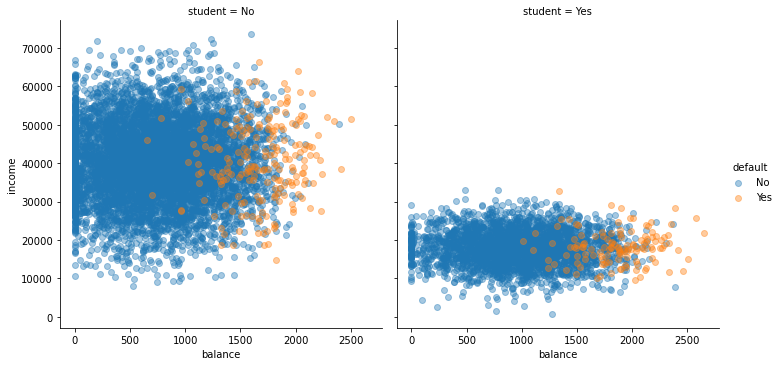

In [12]:
sns.lmplot(x='balance', y='income', hue='default',
           data=default, col='student', fit_reg=False,
           scatter_kws={'alpha':0.4});

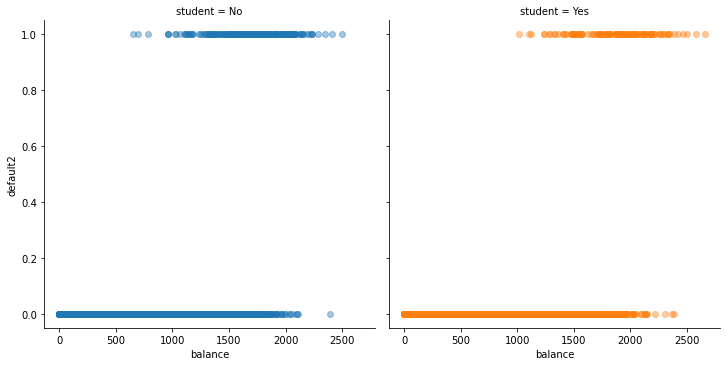

In [13]:
sns.lmplot(x='balance', y='default2', hue='student',
           data=default, col='student', fit_reg=False,
           scatter_kws={'alpha':0.4});

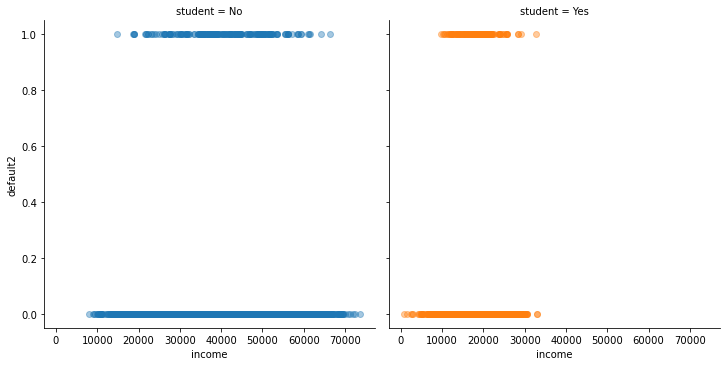

In [14]:
sns.lmplot(x='income', y='default2', hue='student',
           data=default, col='student', fit_reg=False,
           scatter_kws={'alpha':0.4});

In [15]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib widget

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
student = (default.student == 'Yes')
ax.scatter3D(default.balance[student], default.income[student], default.default2[student], zdir='z')
ax.scatter3D(default.balance[~student], default.income[~student], default.default2[~student], zdir='z');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 6

### 6.a

In [16]:
f1 = 'default2 ~ balance + income'
log_fit6 = smf.logit(f1, data=default).fit()
print(log_fit6.summary())

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               default2   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Dec 2020   Pseudo R-squ.:                  0.4594
Time:                        21:50:34   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0

In [17]:
pd.read_html(log_fit6.summary().tables[1].as_html(),header=0, index_col=0)

[                coef   std err       z  P>|z|     [0.025     0.975]
 Intercept -11.540500  0.435000 -26.544    0.0 -12.393000 -10.688000
 balance     0.005600  0.000000  24.835    0.0   0.005000   0.006000
 income      0.000021  0.000005   4.174    0.0   0.000011   0.000031]

### 6.b

In [18]:
def boot_fn(formula, data, index):
    data = data.iloc[index]
    log_fit = smf.logit(formula, data).fit()
    return log_fit.params.values
idx = np.random.permutation(len(default))
boot_fn(f1, default, idx)

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


array([-1.15404684e+01,  5.64710295e-03,  2.08089755e-05])

### 6.c

In [19]:
# bootstrap has to be implemented manually
# TODO

### 7. loocv & weekly data set

In [20]:
weekly = pd.read_csv('../data/Weekly.csv', index_col=0)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
2,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
3,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
4,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
5,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [21]:
X = weekly[['Lag1', 'Lag2']].values
y = weekly['Direction'].map({'Down': 0, 'Up': 1})

sm_log = sm.Logit(y, sm.add_constant(X)).fit()
print(sm_log.summary())

Optimization terminated successfully.
         Current function value: 0.683297
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Dec 2020   Pseudo R-squ.:                0.005335
Time:                        21:50:34   Log-Likelihood:                -744.11
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                   0.01848
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2212      0.061      3.599      0.000       0.101       0.342
x1            -0.0387      0.

### 7.b

In [22]:
sm_log2 = sm.Logit(y[1:], sm.add_constant(X[1:])).fit()

Optimization terminated successfully.
         Current function value: 0.683147
         Iterations 4


### 7.c

In [23]:
sm_log2.predict(sm.add_constant(X)[0])

array([0.57139232])

In [24]:
y.iloc[0]

0

First observation was classified incorrectly.

### 7.d loocv using for loop

In [25]:
# below cell errors out; preparing the data across sm, smf & sklearn is a nightmare
# err = []
# y = y.values
# for i in range(len(X)):
#     loo_x, loo_y = X[i:i+1], y[i]
#     X = np.r_[X[:i], X[i+1:]]
#     y = np.r_[y[:i], y[i+1:]]
#     prob = sm.Logit(y, sm.add_constant(X)).predict(loo_x)
#     err.append(loo_y != (prob > 0.5))
# err

## 8

### 8.a

In [26]:
np.random.seed(42)
x = np.random.randn(100)
y = x - 2*(x**2) + np.random.randn(100)

### 8.b

In [27]:
fig, ax = plt.subplots(1,1)
ax.plot(x, y, 'r.');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### 8.c

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

In [29]:
x = x.reshape(-1,1)

In [30]:
degree = np.arange(1, 5)
deg_mse = []
for deg in degree:
    pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
        ('lin_reg', LinearRegression())
    ])
    mse = [] # store validation set mse for each loo iteration
    for train_idx, valid_idx in LeaveOneOut().split(x, y):
        x_train, y_train = x[train_idx], y[train_idx]
        x_valid, y_valid = x[valid_idx], y[valid_idx]
        #print(x_train.shape, y_train.shape)
        pipe.fit(x_train, y_train)
        #mse.append(pipe.score(x_valid, y_valid)) # R^2 score doesn't work on <2 samples
        mse.append(mean_squared_error(y_valid, pipe.predict(x_valid)))
    deg_mse.append(np.mean(mse))
plt.figure()
plt.plot(degree, deg_mse, 'b-o')
plt.xlabel('degree of polynomial')
plt.ylabel('MSE');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### 8.d

LOO isn't random. 8.d is the same as 8.c

#### 8.e

degree 2 has lower error as the generating model is degree

#### 8.f
sklearn doesn't report std. errors.

## 9. Boston data set

In [31]:
boston = pd.read_csv('../data/Boston.csv', index_col=0)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [32]:
# 9.a
u_hat = boston.medv.mean()
u_hat

22.532806324110698

In [33]:
# 9.b
se_u_hat = boston.medv.std() / np.sqrt(len(boston))
se_u_hat

0.4088611474975351

In [34]:
# 9.c
rng = np.random.default_rng(42)

boot = []
for i in range(1000):
    samples = rng.choice(boston.medv, size=len(boston), replace=True)
    boot.append(np.mean(samples))
u_hat_boot = np.mean(boot)
se_u_hat_boot = np.std(boot)
u_hat_boot, se_u_hat_boot

(22.53367391304348, 0.40898818361867406)

In [35]:
# 9.d 95% CI
(u_hat_boot - 2 * se_u_hat_boot, u_hat_boot + 2 * se_u_hat_boot)

(21.71569754580613, 23.35165028028083)

In [37]:
# 9.e median
# is it the avg. of the 95% CI? i.e. 50 percentile?
np.median(boot)

22.544169960474306

In [38]:
(21.71569754580613 + 23.35165028028083) / 2

22.53367391304348